In [1]:
from graph_stuff import generate_all_clusters, score_cluster, create_groupings, evaluate_clusters

def hierarchical_clustering(adj_matrix):
    '''
    Clusters an adjacency matrix using hierarchical clustering
    '''
    
    # Perform hierarchical clustering
    from scipy.cluster.hierarchy import linkage, fcluster
    Z = linkage(adj_matrix, method='ward', optimal_ordering=True)
    predicted_clusters = fcluster(Z, t=.8, criterion='distance')
    predicted_cluster_map = predicted_clusters.tolist()

    from collections import defaultdict
    clusters_dict = defaultdict(list)
    for index, cluster_id in enumerate(predicted_clusters):
        clusters_dict[cluster_id].append(index)

    predicted_clusters = list(clusters_dict.values())

    return predicted_clusters, Z, predicted_cluster_map

def cluster_grouping(word_array, model, device='cpu'):
    """
    Cluster a group of words using the model to create adjacency matrix.
    
    Args:
        word_array: List of tensors representing IPA words
        model: Trained transformer model
        device: Device to run model on
    
    Returns:
        List of clusters, where each cluster is a list of indices
    """
    n_words = len(word_array)
    
    # Create adjacency matrix
    adj_matrix = torch.zeros((n_words, n_words))
    
    model.eval()
    with torch.no_grad():
        for i in range(n_words):
            for j in range(i + 1, n_words):
                # Create word pair tensor
                word_pair = torch.stack([word_array[i], word_array[j]], dim=0).unsqueeze(0).to(device)
                
                # Create masks (True for padding tokens)
                mask1 = (word_array[i] == 0).unsqueeze(0).to(device)
                mask2 = (word_array[j] == 0).unsqueeze(0).to(device)
                word_pair_masks = torch.stack([mask1, mask2], dim=1).to(device)
                
                # Get similarity score
                similarity = model(word_pair, word_pair_masks).item()
                
                # Fill both triangles of the matrix
                adj_matrix[i, j] = 1 - similarity
                adj_matrix[j, i] = 1 - similarity

    # Convert to squareform
    from scipy.spatial.distance import squareform
    adj_matrix = squareform(adj_matrix.cpu().numpy())

    # Find best clustering
    predicted_clusters = hierarchical_clustering(adj_matrix)
    
    return predicted_clusters

def cluster_and_evaluate_all_meanings(df, model, ipa_to_ids, device='cpu'):
    """Process all word meanings and evaluate clustering using the modular approach."""
    # Step 1: Preprocessing
    groupings = create_groupings(df, ipa_to_ids)
    
    results = {}
    
    # Step 2 & 3: Clustering and Evaluation
    from tqdm.notebook import tqdm
    for meaning, (word_array, cognate_class_label_array, phonological_words, meaning) in tqdm(groupings.items(), total=len(groupings), desc="Groupings"):
        #print(f"\nProcessing meaning: {meaning}")
        #print(f"Number of words: {len(word_array)}")
        
        # Step 2: Clustering
        predicted_clusters, linkage, predicted_cluster_map = cluster_grouping(word_array, model, device)

        import matplotlib.pyplot as plt
        import numpy as np
        from scipy.cluster.hierarchy import dendrogram
        
        plt.figure(figsize=(10, 7))
        dendrogram(linkage, labels=phonological_words, leaf_rotation=0, leaf_font_size=12, orientation='right')
        plt.title('Meaning: ' + meaning)
        #plt.ylabel('Sample index')

        import matplotlib.colors as mcolors
        # Use a larger set of visually distinct colors
        colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
        # Remove duplicates while preserving order
        seen = set()
        colors = [c for c in colors if not (c in seen or seen.add(c))]

        # Access the tick labels and set their colors
        ax = plt.gca()
        y_labels = ax.get_ymajorticklabels()
        for label in y_labels:
            word = label.get_text()
            idx = phonological_words.index(word)
            #cluster_num = predicted_cluster_map[idx]
            from sklearn.preprocessing import LabelEncoder
            numerical_labels = LabelEncoder().fit_transform(cognate_class_label_array)
            cluster_num = numerical_labels[idx]
            color = colors[(cluster_num - 1) % len(colors)]
            label.set_color(color)

        plt.xlabel('Distance')
        plt.show()
        
        # Step 3: Evaluation
        evaluation_results = evaluate_clusters(predicted_clusters, cognate_class_label_array, meaning)
        
        results[meaning] = evaluation_results
        
        print(f"Predicted clusters: {predicted_clusters}")
        print(f"True classes: {cognate_class_label_array}")
        print(f"Accuracy: {evaluation_results['accuracy']:.3f}")
    
    return results

In [2]:
import pandas as pd
import torch
import numpy as np

# Create IPA to ID mapping
import joblib
ipa_embedder = joblib.load("data/embeddings/34.joblib")
ipa_to_ids = ipa_embedder.char_to_idx

# Example of using the modular approach:
from transformer_stuff import TransformerCognateModel
model = torch.load('TransformerCognateModel_34.pt', weights_only=False)
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
model.to(device)

TransformerCognateModel(
  (embedder): Embedding(129, 34, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=34, out_features=34, bias=True)
        )
        (linear1): Linear(in_features=34, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=128, out_features=34, bias=True)
        (norm1): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((34,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=68, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, ou

In [3]:
import pandas as pd
from itertools import combinations

ielexPairsDf = pd.read_csv("data/ielexTest.csv")

ielexPairsDf = ielexPairsDf[['Language', 'Meaning', 'Phonological Form', 'cc']].dropna()
ielexPairsDf.columns = ['Language', 'meaning', 'word', 'cognate_class']

ielexPairs = []

for _, group in ielexPairsDf.groupby('meaning'):
    entries = group.to_dict('records')
    for w1, w2 in combinations(entries, 2):
        word1 = str(w1['word'])
        word2 = str(w2['word'])
        label = int(w1['cognate_class'] == w2['cognate_class'])
        ielexPairs.append((word1, word2, label))

def preprocess(all_pairs, ipa_embedder, device):
    from itertools import chain

    max_length = 0
    for pair in all_pairs:
        for word in pair:
            length = len(word)
            if length > max_length:
                max_length = length
    
    batches = torch.empty((len(all_pairs), 2, max_length), dtype=torch.int, device=device)
    batches_masks = torch.zeros((len(all_pairs), 2, max_length), dtype=torch.bool, device=device)

    from tqdm.notebook import tqdm
    for pair_index, pair in tqdm(enumerate(all_pairs), total=len(all_pairs), desc="Creating batches"):
        for word_index, word in enumerate(pair):
            for letter_index, letter in enumerate(word):
                batches[pair_index, word_index, letter_index] = ipa_embedder.char_to_idx[letter]
            
            batches_masks[pair_index, word_index, len(word):] = True

    return (batches, batches_masks, max_length)

all_pairs = [row[:2] for row in ielexPairs]
all_labels = [row[2] for row in ielexPairs]

ldistance_operations, ldistance_masks, max_length = preprocess(all_pairs, ipa_embedder, device=device)
test_data = list(zip(ldistance_operations, ldistance_masks))

from torch.utils.data import DataLoader
test_loader = DataLoader(test_data, batch_size=1600, generator=torch.Generator(device=torch.get_default_device().type))

predicted_labels = []

from tqdm.notebook import tqdm
for batch in tqdm(test_loader, desc="Testing IELEX against GLED"):
    batch_predicted_labels = model(*batch).squeeze()
    batch_predicted_labels = (batch_predicted_labels > 0.5).int()
    predicted_labels.extend(batch_predicted_labels.tolist())

from sklearn.metrics import classification_report
print(classification_report(all_labels, predicted_labels))

Creating batches:   0%|          | 0/651 [00:00<?, ?it/s]

Testing IELEX against GLED:   0%|          | 0/1 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.95      0.87       409
           1       0.87      0.62      0.72       242

    accuracy                           0.82       651
   macro avg       0.84      0.78      0.80       651
weighted avg       0.83      0.82      0.82       651



In [4]:
df = pd.read_csv("data/ielexTest.csv")
df

,Unnamed: 0,Language,Meaning,Phonological Form,cc,ASJP
0,12,Greek,wind,aˈʝe̞ras,wind:J,aSeras
1,66,Bulgarian,wind,ˈvʲatər,wind:B,vat3r
2,68,Russian,wind,'vʲɛtʲɛr,wind:B,vEtEr
3,69,Polish,wind,vjatr,wind:B,vyatr
4,71,Ukrainian,wind,ˈʋitɛr,wind:B,witEr
...,...,...,...,...,...,...
59,124,French,head,tɛt,head:D,tEt
60,135,Italian,head,'tɛsta,head:D,tEsta
61,136,Romanian,head,kap,head:B,kap
62,143,Breton,head,ˈpɛnː,head:E,pEn


Groupings:   0%|          | 0/3 [00:00<?, ?it/s]

c:\Users\leifm\OneDrive\Documents\Repos\Cognates\.venv\Lib\site-packages\torch\nn\modules\transformer.py:505: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(


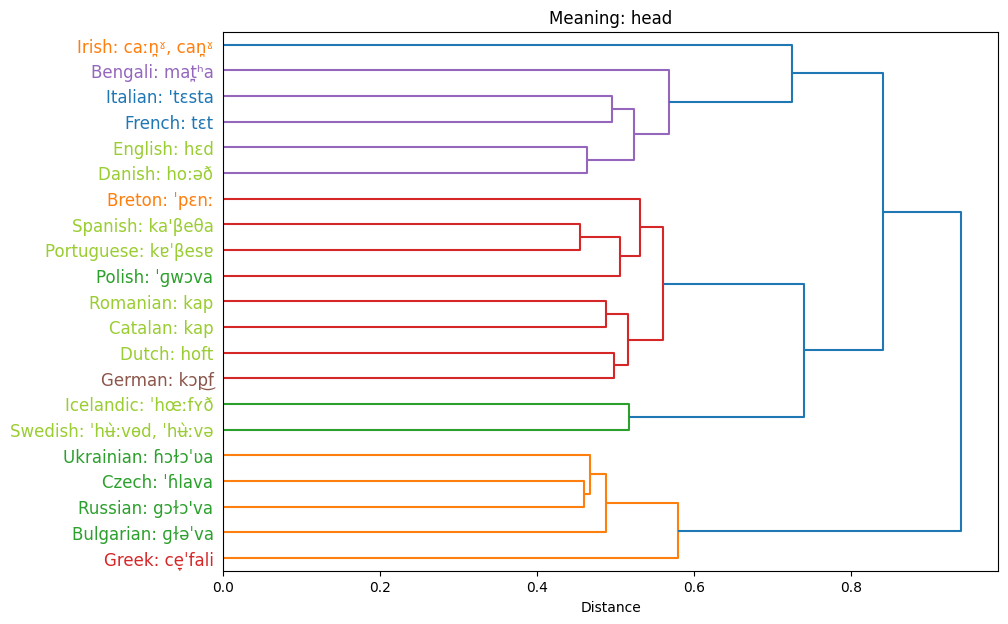

Predicted clusters: [[0, 2, 3, 5, 6], [1, 9, 10, 16, 17, 20], [4, 7, 8, 11, 12, 13, 14, 15, 18, 19]]
True classes: ['G', 'K', 'F', 'F', 'F', 'F', 'F', 'B', 'B', 'B', 'B', 'B', 'O', 'B', 'B', 'B', 'D', 'D', 'B', 'E', 'E']
Accuracy: 0.714


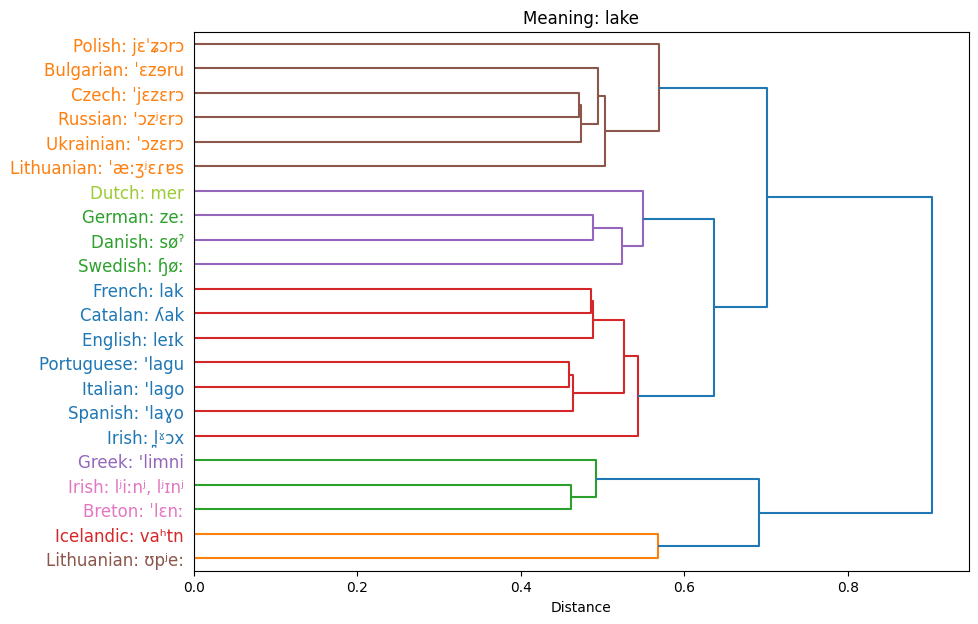

Predicted clusters: [[0, 6, 8, 19, 21], [1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]]
True classes: ['J', 'F', 'F', 'F', 'F', 'F', 'L', 'F', 'H', 'G', 'G', 'E', 'B', 'G', 'E', 'E', 'E', 'E', 'E', 'Z', 'E', 'Z']
Accuracy: 0.541


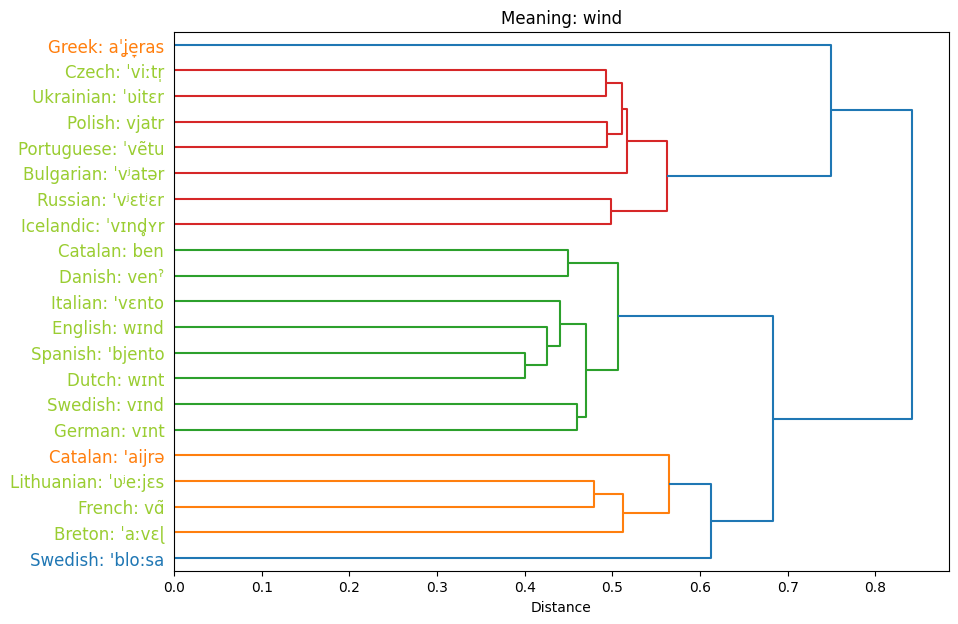

Predicted clusters: [[0, 1, 2, 3, 4, 5, 7, 16], [6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20]]
True classes: ['J', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'I', 'B', 'B', 'B', 'B', 'B', 'B', 'J', 'B', 'B', 'B', 'B', 'B']
Accuracy: 0.486


In [5]:
# Process a single meaning group
# meaning = 'few'
# if meaning in groupings:
#     word_array, cognate_labels = groupings[meaning]
#     clusters = cluster_grouping(word_array, model, device)
#     results = evaluate_clusters(clusters, cognate_labels, meaning)
#     print(f"Results for '{meaning}': {results}")

# Or process all meanings
all_results = cluster_and_evaluate_all_meanings(df, model, ipa_to_ids, device)

In [6]:
accuracies = [r['accuracy'] for r in all_results.values()]
print(f"\nOverall average accuracy: {np.mean(accuracies):.3f}")

f1s = [r['f1'] for r in all_results.values()]
print(f"\nOverall f1 score: {np.mean(f1s):.3f}")

nmis = [r['nmi'] for r in all_results.values()]
print(f"\nOverall nmi score: {np.mean(nmis):.3f}")


Overall average accuracy: 0.580

Overall f1 score: 0.502

Overall nmi score: 0.331


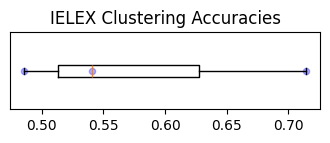

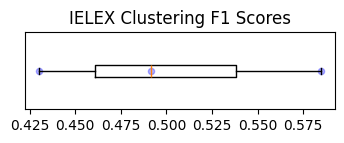

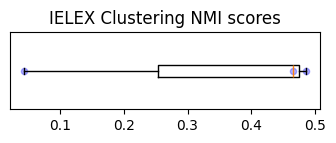

In [7]:
import matplotlib.pyplot as plt
from visualization_stuff import show_box_plot

show_box_plot(accuracies, title="IELEX Clustering Accuracies")
show_box_plot(f1s, title="IELEX Clustering F1 Scores")
show_box_plot(nmis, title="IELEX Clustering NMI scores")